Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 4: Neural Networks

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

This notebook is structured as follows:<br>
[Neural Networkds](#Part1)
1. [Exploratory Data Analysis](#eda)
2. [The Activation and Forwards/Back Propogation Functions](#funcs)
3. [Optimizing for Best Model Paramaeters](#opt)
4. [Model Evaluation](#me)



***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder

from scipy.optimize import minimize

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


<a id="Part1"></a>
# Part 1 - Multi-Class Logistic Regression

Prompt:<br>
Use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.
In the first part of the exercise, you will extend your previous implemen- tion of logistic regression and apply it to one-vs-all classification.

***


OK. Let's dive into the data and begin building the frameworks for multi-class logistic regression.

<a id="eda"></a>
# Exploratory Data Analysis

In [2]:
data = loadmat('ex3/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

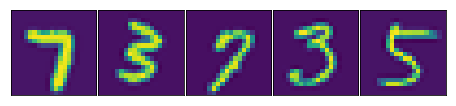

In [4]:
def plot_several(data):
    N = 5
    
    for i in range(1,N+1):
        r = np.random.randint(0,5000)
        ex = np.reshape(data['X'][r], (20,20))
        ex= ex.T
        plt.subplot(1,N,i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(ex)

    plt.tight_layout(pad=-.5)
    return None

plot_several(data)

<a id="prep"></a>
# Preparing the Training and Target Data

In [5]:
X = data['X']
# I'm not adding the bias layer here because we will add it as part of the Neural Network algorithm

y = data['y']

X.shape, y.shape


((5000, 400), (5000, 1))

For the neural network, we need to one-hot encode our target labels. Conveniently, sklearn can do this for you! (Sensing a theme?)  One-hot encoding turns a class label n (out of k classes) into a vector of length k where index n is "hot" (1) while the rest are zero. For more information check out the sklearn documentation on [one-hot-encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [6]:
encoder = OneHotEncoder(sparse=False, categories='auto')
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [7]:
y_onehot[2000,:], y[2000,0]
# looks good. 

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 4)

<a id="funcs"></a>
# The Activation and Forwards/Back Propogation Functions

Before we get going too far building our froward and back propogation functions, we need to make sure we have all the matrix shapes figured out and have the right understanding of matrix multiplication.  With these figured out, implementing the functions is straightforward.

In [8]:
X.shape, y_onehot.shape

((5000, 400), (5000, 10))

In [9]:
# initialize meta paramters
M = len(X)                      # 5000 training examples
num_features = X.shape[1]         # 400 features
hidden_layer_size = 25          # We are choosing the hidden layer to have 25 nodes
num_labels = len(np.unique(y))  # There are 10 labels
reg_scale = 1                   # Manually setting the regularization

X = np.matrix(X)
y = np.matrix(y)

In [10]:
# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_layer_size * \
                (num_features + 1) + num_labels * (hidden_layer_size + 1)) - 0.5) * 0.25
params.shape

(10285,)

In [11]:
# bundle the parameter array into parameter matrices for each layer
# plus ones are for the bias term which we will take care of in the propogation functions
theta1 = np.matrix(np.reshape(params[:hidden_layer_size * (num_features + 1)], (hidden_layer_size, (num_features + 1))))
theta2 = np.matrix(np.reshape(params[hidden_layer_size * (num_features + 1):], (num_labels, (hidden_layer_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

Good! Our matrices have the right shape. In addition, we have randomly initialized them to some finite value. We don't want to initialize our model paramter matrices to zero for neural networks.

Let's write our functions.

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
def Forward_Prop(X, theta1, theta2):
    """
    X should be a matrix without bias terms added
    theta1 and theta2 are the model parameters matrices
    
    returns the activation layer matrices (the a's) and the transfer matrices (the z's)
    return the final hypothesis of the neural network
    """
    M = len(X)
    
    a1 = np.insert(X, 0, values=np.ones(M), axis=1) #add bias term
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(M), axis=1) # add bias term
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

Let's double check that this gives us matrix shapes that make sense.

In [14]:
a1, z2, a2, z3, h = Forward_Prop(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

Great! Let's write the cost funciton next. The cost function computes the total error between y_onehot and h.

In [15]:
def Reg_Cost(params, num_features, hidden_layer_size, num_labels, X, y, reg_scale):
    """
    X should already be a matrix, without the bias term included
    """
    M = len(X)

    # bundle the parameter array into parameter matrices for each layer
    # plus ones are for the bias term which we will take care of in the propogation functions
    theta1 = np.matrix(np.reshape(params[:hidden_layer_size * (num_features + 1)], \
                                  (hidden_layer_size, (num_features + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_layer_size * (num_features + 1):], \
                                  (num_labels, (hidden_layer_size + 1))))

    # run forward propogation
    a1, z2, a2, z3, h = Forward_Prop(X, theta1, theta2)
    
    # compute the cost and sum over all training examples
    J = 0
    for i in range(M):
        # Logistic activation function, so Logistic cost function
        a = np.multiply(-y[i,:], np.log(h[i,:]))
        b = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(a - b)
    
    J = J / M
    
    #Include regularization
    J += (reg_scale/(2 * M)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

In [16]:
# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_layer_size * \
                (num_features + 1) + num_labels * (hidden_layer_size + 1)) - 0.5) * 0.25
#Calculate the cost for this random initialization
Reg_Cost(params, num_features, hidden_layer_size, num_labels, X, y_onehot, reg_scale)

6.995653654167933

Well, that's a number. Our regularized cost function appears to work! 

Next, we need to write the back propogation function. The backprop algorithm requires the gradient of the sigmoid function.

In [17]:
def SigGrad(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

Now the hard part - Regularized backpropogation!

In [18]:
def Back_Prop(params, num_features, hidden_layer_size, num_labels, X, y, reg_scale):
    M = len(X)
    
    # bundle the parameter array into parameter matrices for each layer
    # plus ones are for the bias term which we will take care of in the propogation functions
    theta1 = np.matrix(np.reshape(params[:hidden_layer_size * (num_features + 1)], \
                                  (hidden_layer_size, (num_features + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_layer_size * (num_features + 1):], \
                                  (num_labels, (hidden_layer_size + 1))))
    
    # run forward propogation
    a1, z2, a2, z3, h = Forward_Prop(X, theta1, theta2)

    # compute the cost
    J = 0 #initialize cost to zero
    for i in range(M):
        # Logistic activation function, so Logistic cost function
        a = np.multiply(-y[i,:], np.log(h[i,:]))
        b = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(a - b)
    J = J / M
    #Include regularization
    J += (reg_scale/(2 * M)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    #End of cost calculation
    
    
    # initialize backprop matrices
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # perform backpropagation
    for t in range(M):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, SigGrad(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / M
    delta2 = delta2 / M
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * reg_scale) / M
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * reg_scale) / M
    
    # flatten the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [20]:
# initialize meta paramters
M = len(X)                      # 5000 training examples
num_features = X.shape[1]       # 400 features
hidden_layer_size = 25          # We are choosing the hidden layer to have 25 nodes
num_labels = len(np.unique(y))  # There are 10 labels
reg_scale = 1                   # Manually setting the regularization

# Make sure the X, y_onehot are the right matrices
X = np.matrix(data['X'])
y = data['y']
y_onehot = np.matrix(encoder.fit_transform(y))

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_layer_size * \
                (num_features + 1) + num_labels * (hidden_layer_size + 1)) - 0.5) * 0.25

J, grad = Back_Prop(params, num_features, hidden_layer_size, num_labels, X, y_onehot, reg_scale)
J, grad.shape

(7.101090261559295, (10285,))

OK! Now let's find the best parameters for theta1 and theta2 by minimizing the Back_Prop function.
<a id="opt"></a>
# Optimizing for Best Model Paramaeters 

In [21]:

# minimize the objective function
fmin = minimize(fun=Back_Prop, x0=params, \
                args=(num_features, hidden_layer_size, num_labels, X, y_onehot, reg_scale), \
                method='TNC', jac=True, options={'maxiter': 500})
fmin


     fun: 0.3128293355199887
     jac: array([ 1.81265052e-04, -1.16513187e-08,  8.62987072e-09, ...,
        6.34760122e-05,  1.88919550e-05,  2.39106196e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 500
     nit: 32
  status: 3
 success: False
       x: array([-4.52054987e-01, -5.82565937e-05,  4.31493536e-05, ...,
        1.43411706e+00,  1.48161769e+00, -1.60150202e+00])

Well, that took a long time to complete. And in the end I had to set maximum iterations to 500 to keep it from taking forever. Even with limiting the number of  It spit out some model parameters. Note that these model parameters are flattened out and we have to reshape them into theta1 and theta2. This is an annoying feature of the scipy minimize function, but it really has no understanding that I want to solve a neural network problem. It's up to me to figure out how to correctly write the Back_prop function to return the flattened gradient array.
<a id="me"></a>
# Model Evaluation

In [22]:
X = np.matrix(data['X'])

theta1 = np.matrix(np.reshape(fmin.x[:hidden_layer_size * (num_features + 1)], \
                              (hidden_layer_size, (num_features + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_layer_size * (num_features + 1):], \
                              (num_labels, (hidden_layer_size + 1))))

a1, z2, a2, z3, h = Forward_Prop(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])

In [23]:
y.shape, y_pred.shape

((5000, 1), (5000, 1))

In [27]:
acc = accuracy_score(y, y_pred)
print(' ')
print('Accuracy: {:.4}'.format(acc))
print(' ')

 
Accuracy: 0.9966
 


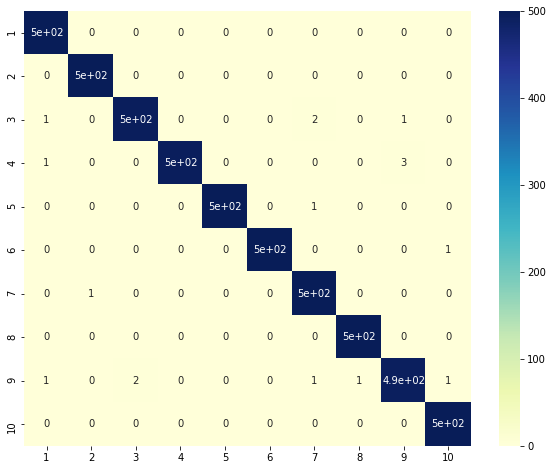

In [25]:
# Plot confusion matrix for C=1 regularization
conf = confusion_matrix(y, y_pred)

indices = range(1,11)
cols = range(1,11)

df_cm = pd.DataFrame(conf.astype(int), index = indices,
                  columns = cols)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

Pretty incredible, right? The it takes a lot longer to train the neural network than logistic regression, but the model performance is quite a bit better.  It's probably overfitting, even with finite L2 regularization. But I'm not going to take the time to re-run it on a learning curve with a proper train/test split. 